In [1]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

In [2]:
from tensorflow.contrib.slim.python.slim.nets import resnet_v2
def model(inputs, num_classes, is_training=False, scope='model', reuse=None):
    with slim.arg_scope(resnet_v2.resnet_arg_scope(weight_decay=0.0005)):
        logits, endpts = resnet_v2.resnet_v2_50(inputs, num_classes, is_training=is_training, reuse=reuse, scope=scope)
    return logits, endpts

/home/weijia.wu/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


('prob:', <tf.Tensor 'model/predictions/Reshape_1:0' shape=(3, 1, 1, 10) dtype=float32>)
('lables:', <tf.Tensor 'Placeholder_1:0' shape=(3, 10) dtype=float32>)
('cost:', <tf.Tensor 'mul:0' shape=(3, 3, 10) dtype=float32>)
('y_c:', <tf.Tensor 'Sum_1:0' shape=(3, 3, 10) dtype=float32>)
('target_conv_layer_grad:', <tf.Tensor 'gradients/model/block4/unit_3/bottleneck_v2/add_grad/Reshape_1:0' shape=(3, 7, 7, 2048) dtype=float32>)
('gb_grad:', <tf.Tensor 'gradients_1/sub_grad/Reshape:0' shape=(3, 224, 224, 3) dtype=float32>)
INFO:tensorflow:Restoring parameters from /home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/tmp/model.ckpt
('prob_np:', array([[5]]))
('prob_np:', array([[4]]))
('prob_np:', array([[[2.0294574e-06, 2.7508229e-06, 6.2631639e-06, 6.7738227e-05,
         9.4055367e-01, 1.0616214e-06, 1.0351009e-05, 5.8868568e-02,
         4.8755415e-04, 5.8119181e-08]]], dtype=float32))
('grads_val shape:', (7, 7, 2048))
('gb_viz shape:', (224, 224, 3))


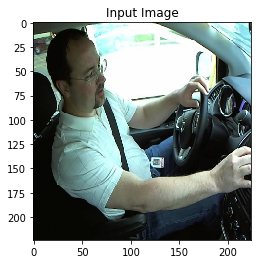

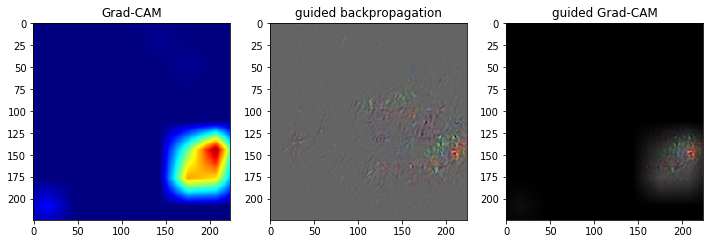

('grads_val shape:', (7, 7, 2048))
('gb_viz shape:', (224, 224, 3))


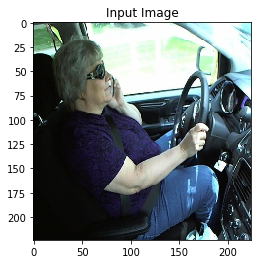

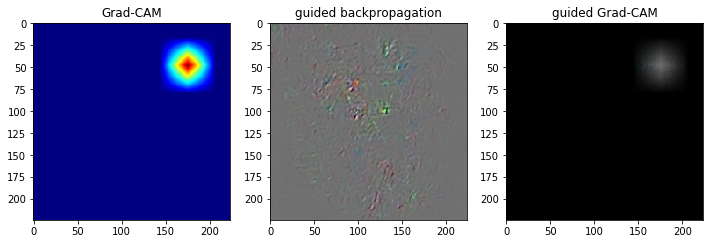

('grads_val shape:', (7, 7, 2048))
('gb_viz shape:', (224, 224, 3))


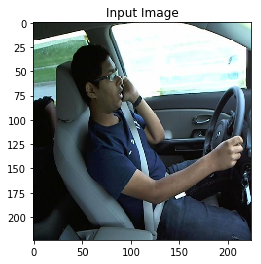

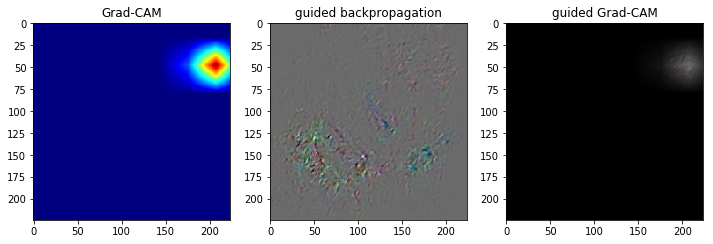

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
import numpy as np

slim = tf.contrib.slim



import utils

# Create mini-batch for demo

import os 
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='2'
# Create mini-batch for demo

# Get normalized input. VGG network handles the normalized image internally. 
img1 = utils.load_image("/home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/test/img_27133.jpg")
img2 = utils.load_image("/home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/test/img_63347.jpg")
img3 = utils.load_image("/home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/test/img_50167.jpg")

batch1_img = img1.reshape((1, 224, 224, 3))
batch1_label = np.array([1 if i == 5 else 0 for i in range(10)])  # 1-hot result for Boxer
batch1_label = batch1_label.reshape(1, -1)

batch2_img = img2.reshape((1, 224, 224, 3))
batch2_label = np.array([1 if i == 4 else 0 for i in range(10)])  # 1-hot result for Shih-Tzu
batch2_label = batch2_label.reshape(1, -1)

batch3_img = img3.reshape((1, 224, 224, 3))
batch3_label = np.array([1 if i == 4 else 0 for i in range(10)])  # 1-hot result for tiger
batch3_label = batch3_label.reshape(1, -1)

batch_img = np.concatenate((batch1_img, batch2_img, batch3_img), 0)
batch_label = np.concatenate((batch1_label, batch2_label, batch3_label), 0)
batch_size = 3



        
        
# Run tensorflow 

with tf.Session() as sess:    
    
# Create tensorflow graph for evaluation


    images = tf.placeholder("float", [batch_size, 224, 224, 3])
    labels = tf.placeholder(tf.float32, [batch_size, 10])

    preprocessed_images = utils.resnet_preprocess(images)

#     with slim.arg_scope(resnet_v2.resnet_arg_scope()):
#         with slim.arg_scope([slim.batch_norm], is_training=False):
#             net, end_points = resnet_v2.resnet_v2_50(preprocessed_images, 10)
    net, end_points = model(preprocessed_images , 10)

    prob = end_points['predictions'] # after softmax
    print('prob:', prob)

    print('lables:', labels)
    cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(prob)), axis=1)
    print('cost:', cost)

    # Get last convolutional layer gradient for generating gradCAM visualization
    # print('endpoints:', end_points.keys())
    target_conv_layer = end_points['model/block4/unit_3/bottleneck_v2/conv3']
    # target_conv_layer = end_points['resnet_v1_50/block3/unit_5/bottleneck_v1']

    # gradient for partial linearization. We only care about target visualization class. 
    y_c = tf.reduce_sum(tf.multiply(net, labels), axis=1)
    print('y_c:', y_c)
    target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]
    print('target_conv_layer_grad:', target_conv_layer_grad)

    # Guided backpropagtion back to input layer
    gb_grad = tf.gradients(cost, images)[0]          #
    print('gb_grad:', gb_grad)

    init = tf.global_variables_initializer()

    latest_checkpoint = '/home/weijia.wu/workspace/Kaggle/State_farm_distracted_driver_detection/tmp/model.ckpt'

    saver = tf.train.Saver()
    sess.run(init)
    
    saver.restore(sess,latest_checkpoint)    
    
    prob_np = sess.run(prob, feed_dict={images: batch_img})
    print('prob_np:', sess.run(tf.argmax(tf.nn.softmax(prob_np[0]),axis=-1)))
    print('prob_np:', sess.run(tf.argmax(tf.nn.softmax(prob_np[1]),axis=-1)))
    
    print('prob_np:', prob_np[1])
    # cost_np, gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([cost, gb_grad, target_conv_layer, target_conv_layer_grad], feed_dict={images: batch_img, labels: prob_np})
    net_np, y_c_np, gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([net, y_c, gb_grad, target_conv_layer, target_conv_layer_grad], feed_dict={images: batch_img, labels: batch_label})
    
    for i in range(batch_size):

        utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gb_grad_value[i])
    